In [29]:
import math
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [30]:
class function:
    def __init__(self, dim, value, grad, hessian):
        self.dim = dim
        self.value = value
        self.grad = grad
        self.hessian = hessian

In [31]:
class probleme:
    def __init__(self, f):
        self.f = f
        
    def __call__(self, x):
        return self.f.value(x)

In [32]:
f_d = {
    "dim": 1,
    "value": lambda x: x[0]**2 - 5 * x[0] + 3,
    "grad": lambda x: np.array([2*x[0] - 5]),
    "hessian": lambda x: np.diag([2])
}
f_1 = function(**f_d)
P = probleme(f_1)

In [33]:
f_2_d = {
    "dim": 2,
    "value": lambda x: x[0]**2 + x[1]**2,
    "grad": lambda x: np.array([2*x[0], 2*x[1]]),
    "hessian": lambda x: np.diag([2, 2])
}

f_2 = function(**f_2_d)

# Méthode de Newton

In [34]:
def backtracking(f, x, alpha=0.1, beta=0.8):
    t = 1
    desc_d = -1 * f.grad(x)
    while f.value(x + desc_d * t) > f.value(x) + alpha * t * np.dot(f.grad(x).T, desc_d):
        t = beta * t
    return t, desc_d

In [35]:
def constant(*args):
    return 0.01

In [37]:
class Newton:
    def __init__(self, f, pas, epsilon=0.01):
        self.epsilon = epsilon
        self.f = f
        self.pas = pas
        self.save = np.array([])
        self.dirs = np.array([])
        
    def __call__(self, x0):
        self.save = []
        self.dirs = []
        x = x0
        self.save.append(x)
        dxN = -1 * np.dot(np.linalg.inv(self.f.hessian(x)), self.f.grad(x))
        lmd = -1 * np.dot(self.f.grad(x).T, dxN)
        while lmd / 2 > self.epsilon:
            dxN = -1 * np.dot(np.linalg.inv(self.f.hessian(x)), self.f.grad(x))
            lmd = -1 * np.dot(self.f.grad(x).T, dxN)
            (t, dire) = self.pas(self.f, x)
            self.dirs.append(dire)
            x = x + t * dxN
            self.save.append(x)
        self.save = np.array(self.save)
        self.dirs = np.array(self.dirs)
        return x
    
    def plot(self):
        if self.save.shape[0] == 0:
            raise Exception("The Newton method algorithm has not been run")
        if self.f.dim == 1:
            plt.figure(figsize=(15, 15))
            x = np.linspace(-1 * self.save.max() - 5, self.save.max() + 5, 1000).reshape((1, -1))
            plt.plot(x.reshape((-1)), self.f.value(x))
            plt.scatter(self.save[:, 0], self.f.value(self.save[:, 0].reshape(1, -1)), 50, c="red")
            plt.grid()
            plt.show()
        elif self.f.dim == 2:
            plt.figure(figsize=(15, 15))
            x, y = np.linspace(-1 * self.save[:, 0].max() - 5, self.save[:, 0].max() + 5, 200), np.linspace(- 1 * self.save[:, 1].max() - 5, self.save[:, 1].max() + 5, 200)
            X, Y = np.meshgrid(x, y)
            x_y = np.vstack([X.reshape(1, -1), Y.reshape(1, -1)]).reshape(2, -1)
            plt.contour(X, Y, self.f.value(x_y).reshape(200, -1), 15)
            plt.scatter(self.save[:, 0], self.save[:, 1], 50, c="red")
            plt.grid()
            plt.show()
        else:
            raise Exception("Dimension > 2 not implemented")

In [38]:
meth = Newton(f_1, backtracking)
meth(np.array([100]))
print(meth.dirs)

[[-1.95e+02]
 [-3.90e+01]
 [-7.80e+00]
 [-1.56e+00]
 [-3.12e-01]
 [-6.24e-02]]


# Descente de Gradient

In [39]:
class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    
    """    
    def __init__(self, ddir=None, rate=None, decay=None, tol=None, max_iter=None):
        """        
        Instantiates a GD object.
    
        Attributes:
        ddir: function computing descent direction.
        rate: function computing learning rate ; takes in
              - x (ndarray): current iterate
              - f (function): objective function
              - dir_x (ndarray) : descent direction
              - grad (function) : gradient function
              - nb_iter (int): number of iterations.
              - eta (float): hyper-parameter.
        decay: function computing decay.
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
    
        """
        self.ddir = ddir if ddir else (lambda x, f, grad, tol: - grad(x, f, tol))
        self.rate = rate if rate else (lambda x, f, dir_x, grad, nb_iter, eta : 0.01)
        self.decay = decay if decay else (lambda x, f, grad, tol: np.linalg.norm(grad(x, f, tol)))
        self.tol = tol if tol else 1e-6
        self.max_iter = max_iter if max_iter else 1000
    
    def __call__(self, x, f, grad, verbose=False):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
            grad: function outputing gradient value of function f at a given point.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
            (ndarray) list of graidents of iterates.
            (int) number of iterations.
            
        """
        x = x.reshape(1, -1)
        eta = 0
        n_iter = 0

        dir_x = self.ddir(x, f, grad, self.tol)
        rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
        delta_x = rate_ * dir_x
        iters, iters_dir = x, delta_x
        
        decay_x = self.decay(x, f, grad, self.tol)
        while decay_x > self.tol and n_iter < self.max_iter:
            ## Deciding on direction
            dir_x = self.ddir(x, f, grad, self.tol)
            rate_ = self.rate(x, f, dir_x, grad, n_iter, eta)
            delta_x =  rate_ * dir_x
            
            # Storing iterates
            iters = np.vstack([iters, x])
            
            ## Updating iterate
            x = x + delta_x
            
            ## Storing directions
            iters_dir = np.vstack([iters_dir, delta_x])
            
            ## Computing decay
            decay_x = self.decay(x, f, grad, self.tol)
            
            ## Updating iteration number
            n_iter += 1
            
        if decay_x > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        
        if verbose:
            msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
            print(msg.format(n_iter, x.flatten(), f(x), decay_x))
        
        return (x, iters, iters_dir, n_iter)

In [40]:
GD_default = GD()

In [41]:
op_pt, iters, iters_dir, n_iter = GD_default(np.array([10]), (lambda x : f_1.value ([x])),
                                             (lambda x, f, tol : f_1.grad(x)), True)

 Iteration nu. = 818
 approx. = [2.5000005]
 ob value = [[-3.25]]
 and decay = 9.977487120949036e-07.


In [42]:
newt = Newton(f_1, backtracking)
newt(np.array([10]))
print(newt.dirs)

[[-15.  ]
 [ -3.  ]
 [ -0.6 ]
 [ -0.12]]


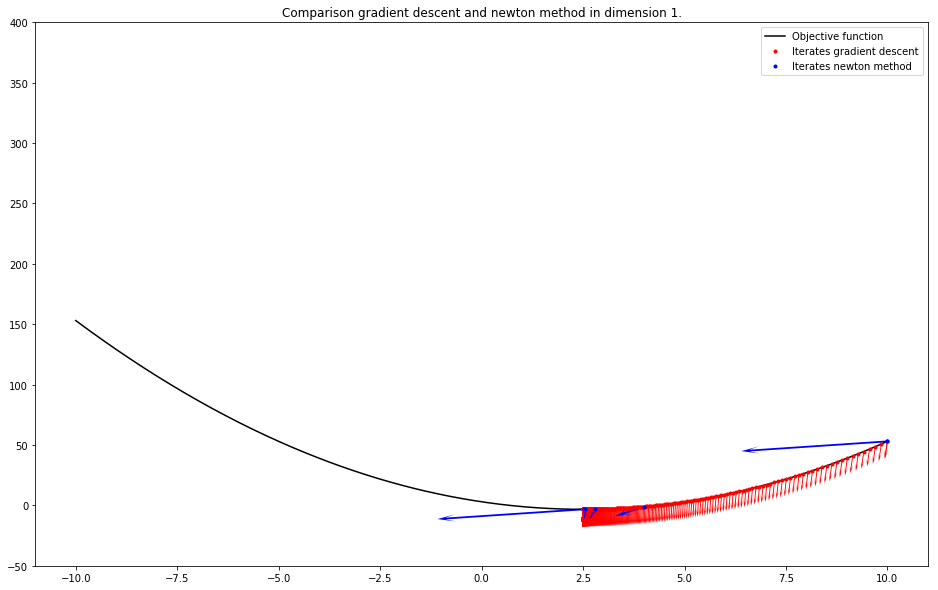

In [50]:
fig, ax = plt.subplots(figsize=(16, 10))
f = lambda x: f_1.value(x.reshape(1, -1))
x = np.linspace(-10, 10, 600)
ax.set_ylim(-50, 400)
ax.plot(x, f(x), "k-", label="Objective function")
# reshaping iters for input
iters_reshape = iters.reshape(iters.shape[0], 1)
ax.plot(iters_reshape, f(iters_reshape), 'r.', label="Iterates gradient descent")
ax.quiver(iters_reshape, f(iters_reshape), iters_dir, -1, 
          color='r', scale=None, width=0.001, headwidth=4, headlength=10)

ax.plot(newt.save, f(newt.save), 'b.', label="Iterates newton method")
ax.quiver(newt.save, f(newt.save), newt.dirs, -1, 
          color='b', scale=None, width=0.002, headwidth=4, headlength=10)

ax.set_title("Comparison gradient descent and newton method in dimension 1.")
ax.legend()
print()